# 卷积神经网络高级

In [1]:
import torch

# torchversion是基于处理图像视频的pytorch包
# torchvision.transforms提供一般的图像转换操作类
from torchvision import transforms
# torchvision.datasets 是用来进行数据加载的
from torchvision import datasets

from torch.utils.data import DataLoader
# 激活函数
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# 准备数据
 
batch_size = 64
#我们拿到的图片是pillow,我们要把他转换成模型里能训练的tensor也就是张量的格式
# ToTensor()转换为张量，Normalize归一化(均值和方差),都是经验值
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
 

In [3]:
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        # 16x1x1的分支        
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        
        # 先16x1x1再24x5x5的分支      
        self.branch5x5_1 = torch.nn.Conv2d(in_channels,16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        # 先16x1x1再24x3x3再24x3x3的分支      
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
        # 先池化再24x1x1的分支，只需要实例化24x1x1的模块      
        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)
        
    def forward(self, x):
        # 调用16x1x1得到一个模块
        branch1x1 = self.branch1x1(x)
        
        # 调用先16x1x1再24x5x5得到一个模块
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        # 调用先16x1x1再24x3x3再24x3x3得到一个模块
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
        
        # 调用先平均池化再24x1x1得到一个模块
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        # 拼接上述模块   
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        
        # dim=1即以通道为维度(batch,channel,w,h)   
        return torch.cat(outputs, dim=1)
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5)
        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)
        self.mp = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(1408, 10)
    def forward(self, x):
        in_size = x.size(0)
        # 输出通道为10        
        x = F.relu(self.mp(self.conv1(x)))
        # 输入通道10,incep1后输出通道为88=16+24+24+24        
        x = self.incep1(x)
        # 输出通道为20        
        x = F.relu(self.mp(self.conv2(x)))
        # 输入通道20,incep2后输出通道为88        
        x = self.incep2(x)
        # 改变张量形状，获得in_size*1408的矩阵        
        x = x.view(in_size, -1)
        # 全链接 1408->10       
        x = self.fc(x)
        return x
model = Net()


In [4]:
# 把计算迁移到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incep1): InceptionA(
    (branch1x1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_pool): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incep2): InceptionA(
    (branch1x1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
   

In [5]:
# 构造损失和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)# #lr为学习率

[1,   300] loss: 0.913
[1,   600] loss: 0.199
[1,   900] loss: 0.150
accuracy on test set: 96 % 
[2,   300] loss: 0.107
[2,   600] loss: 0.096
[2,   900] loss: 0.090
accuracy on test set: 97 % 
[3,   300] loss: 0.079
[3,   600] loss: 0.074
[3,   900] loss: 0.067
accuracy on test set: 98 % 
[4,   300] loss: 0.065
[4,   600] loss: 0.061
[4,   900] loss: 0.061
accuracy on test set: 98 % 
[5,   300] loss: 0.053
[5,   600] loss: 0.055
[5,   900] loss: 0.052
accuracy on test set: 98 % 
[6,   300] loss: 0.050
[6,   600] loss: 0.050
[6,   900] loss: 0.046
accuracy on test set: 98 % 
[7,   300] loss: 0.045
[7,   600] loss: 0.043
[7,   900] loss: 0.047
accuracy on test set: 98 % 
[8,   300] loss: 0.039
[8,   600] loss: 0.047
[8,   900] loss: 0.039
accuracy on test set: 98 % 
[9,   300] loss: 0.036
[9,   600] loss: 0.038
[9,   900] loss: 0.042
accuracy on test set: 98 % 
[10,   300] loss: 0.035
[10,   600] loss: 0.036
[10,   900] loss: 0.036
accuracy on test set: 98 % 


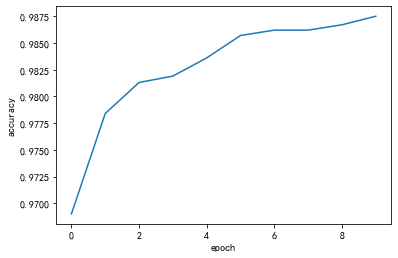

In [6]:
# 训练
 
 
def train(epoch):
    running_loss = 0.0
    # 对于一个可迭代的（iterable）/可遍历的对象（如列表、字符串），enumerate将其组成一个索引序列，利用它可以同时获得索引和值
    # batch_idx显示迭代次数 
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        #  正馈        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # 反馈        
        loss.backward()
        # 更新权重         
        optimizer.step()
        # 把损失加起来         
        running_loss += loss.item()
        #每300次输出一下数据
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
#  测试
def test():
    correct = 0
    total = 0
    #不用算梯度    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # 我们取概率最大的那个数作为输出            
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total
 
# 作图 
if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()